## input: embedded image, keyframe, text query
```
* embedded image folder structure:
|-clip-features-32-b1
    |-clip-features-32
        |-L01_V001.npy
        |-L01_V002.npy
        |...

* keyframe structure:
|-Keyframes_L01
    |-keyframes
        |-L01_V001
            |-001.jpg
            |-002.jpg
            |...
        |-L01_V002
            |-001.jpg
            |-002.jpg
            |...
        |...

* text query: type in preprocess shell
* Both of image folder structure and keyframe structure in test folder
```
## Output: list of keyframe after reranking


# Preprocess

In [1]:
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
import os

# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def embed_text_query(query):
    """
    Embed a text query using CLIP.
    
    Args:
    query (str): The text query to embed.
    
    Returns:
    np.array: The embedding of the text query.
    """
    inputs = processor(text=[query], return_tensors="pt", padding=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features.numpy()

def get_image_ids(folder_path):
    """
    Generate image IDs based on the folder structure: Keyframes_L01/keyframes/L01_V001/001.jpg
    
    Args:
    folder_path (str): Path to the folder containing keyframe subfolders (e.g., path to Keyframes_L01/keyframes).
    
    Returns:
    list: A list of image IDs.
    """
    image_ids = []
    for video_folder in sorted(os.listdir(folder_path)):
        video_path = os.path.join(folder_path, video_folder)
        if os.path.isdir(video_path):
            for file in sorted(os.listdir(video_path)):
                if file.endswith('.jpg') or file.endswith('.png'):
                    # Create image ID in the format L01_V001_001
                    image_id = f"{video_folder}_{os.path.splitext(file)[0]}"
                    image_ids.append(image_id)
    return image_ids

def load_image_embeddings(embeddings_folder):
    """
    Load image embeddings from .npy files.
    
    Args:
    embeddings_folder (str): Path to the folder containing .npy files.
    
    Returns:
    np.array: A 2D array of image embeddings.
    """
    embeddings = []
    for file in sorted(os.listdir(embeddings_folder)):
        if file.endswith('.npy'):
            embedding = np.load(os.path.join(embeddings_folder, file))
            embeddings.append(embedding)
    return np.vstack(embeddings)

text_query_embedding = embed_text_query("The image shows a man and a woman wearing traditional Vietnamese attire, standing outdoors. The woman is dressed in a red áo dài (a traditional Vietnamese long dress) with a matching red circular hat, while the man is wearing a blue áo dài with white patterns and a blue headpiece.")
image_embeddings = load_image_embeddings('/home/fuduweiii/IT/Project/python/pipeline-hcm-ai/test/clip-features-32-b1/clip-features-32')
image_ids = get_image_ids('/home/fuduweiii/IT/Project/python/pipeline-hcm-ai/test/Keyframes_L01/keyframes')
image_ids = np.array(image_ids)



/home/fuduweiii/IT/miniconda3/envs/hcm-ai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-21 22:08:39.115026: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 22:08:39.136991: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-21 22:08:39.292384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the ap

# Initial Retrieval Function:

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def initial_retrieval(text_query_embedding, image_embeddings, top_k=1000):
    """
    Perform initial retrieval of top-k most similar images to the text query.
    
    Args:
    text_query_embedding (np.array): Embedding of the text query (1, D)
    image_embeddings (np.array): Embeddings of all images in the database (N, D)
    top_k (int): Number of top results to retrieve
    
    Returns:
    tuple: (indices of top-k images, similarities of top-k images, embeddings of top-k images)
    """
    similarities = cosine_similarity(text_query_embedding.reshape(1, -1), image_embeddings)[0]
    top_k_indices = np.argsort(similarities)[-top_k:][::-1]
    return top_k_indices, similarities[top_k_indices], image_embeddings[top_k_indices]

# Find Nearest Neighbors Function:

In [3]:
def find_nearest_neighbors(query_embedding, database_embeddings, k=5):
    """
    Find k nearest neighbors for a given query embedding.
    
    Args:
    query_embedding (np.array): Embedding of the query image (1, D)
    database_embeddings (np.array): Embeddings to search in (N, D)
    k (int): Number of nearest neighbors to find
    
    Returns:
    tuple: (indices of k nearest neighbors, similarities of k nearest neighbors)
    """
    similarities = cosine_similarity(query_embedding.reshape(1, -1), database_embeddings)[0]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return top_k_indices, similarities[top_k_indices]

# Weighted Average Pooling Function:

In [4]:
def weighted_average_pooling(embeddings, similarities, beta=0.15):
    """
    Perform weighted average pooling on embeddings.
    
    Args:
    embeddings (np.array): Embeddings to pool (N, D)
    similarities (np.array): Similarity scores for weighting (N,)
    beta (float): Exponent for similarity scores
    
    Returns:
    np.array: Weighted average embedding (D,)
    """
    weights = similarities ** beta
    weighted_sum = np.sum(embeddings * weights[:, np.newaxis], axis=0)
    return weighted_sum / np.sum(weights)   

# Refine Embeddings Function:

In [5]:
def refine_embeddings(top_k_embeddings, neighbors=5, beta=0.15):
    """
    Refine the top-k embeddings using their nearest neighbors.
    
    Args:
    top_k_embeddings (np.array): Embeddings of top-k images (K, D)
    neighbors (int): Number of nearest neighbors to consider
    beta (float): Exponent for similarity scores in weighted average pooling
    
    Returns:
    np.array: Refined embeddings (K, D)
    """
    refined_embeddings = []
    for embedding in top_k_embeddings:
        neighbor_indices, neighbor_similarities = find_nearest_neighbors(embedding, top_k_embeddings, neighbors)
        neighbor_embeddings = top_k_embeddings[neighbor_indices]
        refined_embedding = weighted_average_pooling(neighbor_embeddings, neighbor_similarities, beta)
        refined_embeddings.append(refined_embedding)
    return np.array(refined_embeddings)

# Expand Query Function:

In [6]:
def expand_query(text_query_embedding, top_k_embeddings, neighbors=5):
    """
    Expand the text query embedding using top similar image embeddings.
    
    Args:
    text_query_embedding (np.array): Original text query embedding (1, D)
    top_k_embeddings (np.array): Embeddings of top-k images (K, D)
    neighbors (int): Number of nearest neighbors to consider
    
    Returns:
    np.array: Expanded query embedding (D,)
    """
    query_neighbors = find_nearest_neighbors(text_query_embedding, top_k_embeddings, neighbors)[0]
    return np.max(top_k_embeddings[query_neighbors], axis=0)

# Compute Final Scores Function:

In [7]:
def compute_final_scores(text_query_embedding, refined_embeddings, original_embeddings, expanded_query):
    """
    Compute final similarity scores for reranking.
    
    Args:
    text_query_embedding (np.array): Original text query embedding (1, D)
    refined_embeddings (np.array): Refined embeddings of top-k images (K, D)
    original_embeddings (np.array): Original embeddings of top-k images (K, D)
    expanded_query (np.array): Expanded query embedding (D,)
    
    Returns:
    np.array: Final similarity scores (K,)
    """
    s1 = cosine_similarity(text_query_embedding, refined_embeddings)[0]
    s2 = cosine_similarity(expanded_query.reshape(1, -1), original_embeddings)[0]
    return (s1 + s2) / 2

# SuperGlobal Reranking Function:

In [8]:
def superglobal_reranking(text_query_embedding, image_embeddings, image_ids, top_k=1000, neighbors=5, beta=0.15):
    """
    Perform SuperGlobal Reranking for a text query.
    
    Args:
    text_query_embedding (np.array): Embedding of the text query (1, D)
    image_embeddings (np.array): Embeddings of all images in the database (N, D)
    image_ids (np.array): IDs of all images in the database (N,)
    top_k (int): Number of top results to retrieve and rerank
    neighbors (int): Number of nearest neighbors to consider
    beta (float): Exponent for similarity scores in weighted average pooling
    
    Returns:
    np.array: Reranked image IDs
    """
    # Initial retrieval
    top_k_indices, top_k_similarities, top_k_embeddings = initial_retrieval(text_query_embedding, image_embeddings, top_k)
    
    # Refine embeddings
    refined_embeddings = refine_embeddings(top_k_embeddings, neighbors, beta)
    
    # Expand query
    expanded_query = expand_query(text_query_embedding, top_k_embeddings, neighbors)
    
    # Compute final scores
    final_scores = compute_final_scores(text_query_embedding, refined_embeddings, top_k_embeddings, expanded_query)
    
    # Rerank
    reranked_indices = np.argsort(final_scores)[::-1]
    
    # Ensure all arrays are numpy arrays and have compatible dtypes
    top_k_indices = np.array(top_k_indices, dtype=int)
    reranked_indices = np.array(reranked_indices, dtype=int)
    image_ids = np.array(image_ids)
    
    # Use integer indexing
    reranked_image_ids = image_ids[top_k_indices[reranked_indices]]
    
    return reranked_image_ids

In [9]:
# Assuming you have these variables prepared:
# text_query_embedding: the CLIP embedding of your text query
# image_embeddings: CLIP embeddings of all images in your database
# image_ids: corresponding IDs for all images

reranked_ids = superglobal_reranking(text_query_embedding, image_embeddings, image_ids)

# The reranked_ids will contain the IDs of the images, ordered by relevance after reranking

In [13]:
print(reranked_ids[0:50])

['L01_V023_029' 'L01_V023_028' 'L01_V023_030' 'L01_V023_033'
 'L01_V023_027' 'L01_V023_031' 'L01_V001_052' 'L01_V008_054'
 'L01_V030_116' 'L01_V023_024' 'L01_V020_030' 'L01_V030_122'
 'L01_V006_083' 'L01_V007_082' 'L01_V006_085' 'L01_V023_026'
 'L01_V024_060' 'L01_V023_025' 'L01_V006_080' 'L01_V013_044'
 'L01_V023_032' 'L01_V021_202' 'L01_V015_072' 'L01_V030_093'
 'L01_V021_092' 'L01_V001_070' 'L01_V030_123' 'L01_V021_037'
 'L01_V016_194' 'L01_V013_043' 'L01_V023_023' 'L01_V021_200'
 'L01_V029_049' 'L01_V017_081' 'L01_V006_084' 'L01_V003_096'
 'L01_V003_040' 'L01_V023_230' 'L01_V006_078' 'L01_V001_066'
 'L01_V030_121' 'L01_V023_089' 'L01_V024_141' 'L01_V007_044'
 'L01_V016_040' 'L01_V025_019' 'L01_V014_201' 'L01_V030_110'
 'L01_V022_192' 'L01_V030_124']


### Image query: L01_V023_029

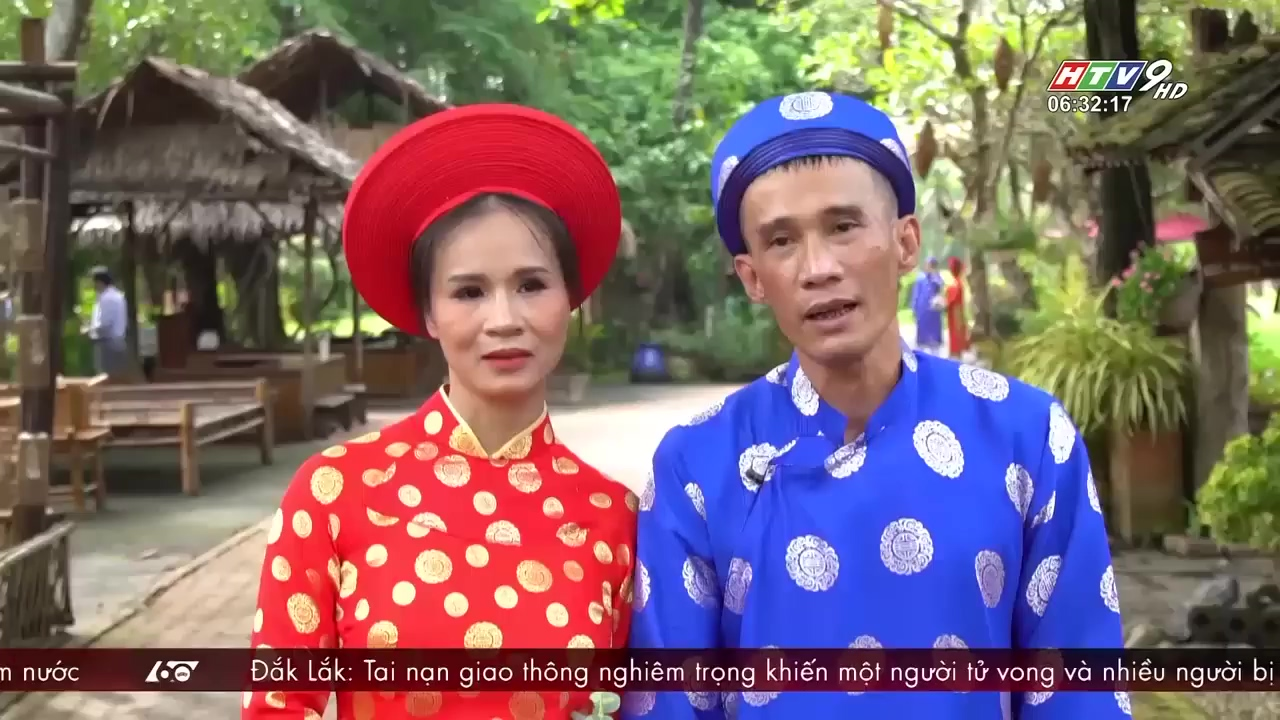

In [12]:
from IPython.display import Image, display

display(Image(filename='/home/fuduweiii/IT/Project/python/pipeline-hcm-ai/test/Keyframes_L01/keyframes/L01_V023/029.jpg'))